# [0] 미션 설명

데이터 EDA (Exploratory Data Analysis)를 통해 대회 데이터를 살펴보는 시간을 갖습니다.

> **학습 목표**
> - 대회에서 사용하는 데이터의 형식 및 구조를 파악한다.
> - 분석에 활용할만한 인사이트를 탐색한다.


RecSys 기초 대회 강의에서는Book Crossing 데이터를 사용하여, 모든 실습 및 미션, 대회를 진행합니다. [Kaggle Book-Crossing](https://www.kaggle.com/datasets/ruchi798/bookcrossing-dataset) 을 출처로 하며, 데이터는 재구성되어 제공되었습니다. 해당 데이터는 CC0: Public Domain 라이센스임을 밝힙니다.


# [1] 데이터 불러오기



본 대회에 활용되는 데이터는 총 3개의 파일입니다.

- user : 사용자 정보를 담고 있는 데이터 파일

- ratings: 책의 등급을 1-10으로 표현한 데이터 파일

- books: 책과 관련된 정보를 표현한 데이터 파일

먼저 세 파일을 로드하는 과정을 수행하겠습니다.

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import torch
import torch.nn as nn

In [2]:
path='./data/'

users = pd.read_csv(path+'users.csv')
books = pd.read_csv(path+'books.csv')
train_ratings = pd.read_csv(path+'train_ratings.csv')
test_ratings = pd.read_csv(path+'test_ratings.csv')


print('users shape: ', users.shape)
print('books shape: ', books.shape)
print('ratings shape: ', ratings.shape)

users shape:  (68092, 3)
books shape:  (149570, 10)


NameError: name 'ratings' is not defined

,user_id,isbn,rating
0,8,0002005018,4
1,67544,0002005018,7
2,123629,0002005018,8
3,200273,0002005018,8
4,210926,0002005018,9
...,...,...,...
306790,278843,0743525493,7
306791,278851,067161746X,6
306792,278851,0884159221,7
306793,278851,0912333022,7



> 1.   users.csv
> 2.   books.csv
> 3.   ratings.csv

순서대로 EDA를 진행해 보겠습니다.

각 데이터 셋을 열어 데이터를 꼼꼼히 살펴보며 cleaning 을 수행해보고, 간단한 Feature Engineering을 통해 인사이트를 탐색해보겠습니다.

#[2] users

사용자의 정보를 담고 있는 파일입니다.

총 70753 명의 사용자 정보를 담고 있습니다.

`user_id`, `location`, `age` 컬럼으로 구성되어있습니다.

`user_id`는 unique한 값을 나타냅니다.


In [3]:
users.head()

,user_id,location,age
0,8,"timmins, ontario, canada",NaN
1,11400,"ottawa, ontario, canada",49.0
2,11676,"n/a, n/a, n/a",NaN
3,67544,"toronto, ontario, canada",30.0
4,85526,"victoria, british columbia, canada",36.0


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68092 entries, 0 to 68091
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   68092 non-null  int64  
 1   location  68092 non-null  object 
 2   age       40259 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.6+ MB


In [5]:
users.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,68092.0,139381.329539,80523.969862,8.0,69008.75,138845.5,209388.25,278854.0
age,40259.0,36.069873,13.842571,5.0,25.00,34.0,45.00,99.0


In [6]:
users['user_id'].nunique()

68092

In [7]:
users.isna().sum()/len(users)

user_id     0.000000
location    0.000000
age         0.408756
dtype: float64

age에 많은 결측값이 있는 것을 확인할 수 있습니다.

## (2-1) Preprocessing & Feature Engineering

현재 `location` 칼럼에는 지역, 주, 국가 순서로 모든 정보가 다 들어와있습니다.

이를 전처리를 통해 각각 컬럼으로 분리하는 과정을 거치겠습니다.

In [8]:
users['location'] = users['location'].apply(lambda x: re.sub(r'[^0-9a-zA-Z:,]', '',x)) # 특수문자 제거
users['location_city'] = users['location'].apply(lambda x: x.split(',')[0].strip())
users['location_state'] = users['location'].apply(lambda x: x.split(',')[1].strip())
users['location_country'] = users['location'].apply(lambda x: x.split(',')[2].strip())

users = users.replace('na', np.nan) #특수문자 제거로 n/a가 na로 바뀌게 되었습니다. 따라서 이를 컴퓨터가 인식할 수 있는 결측값으로 변환합니다.
users = users.replace('', np.nan) # 일부 경우 , , ,으로 입력된 경우가 있었으므로 이런 경우에도 결측값으로 변환합니다.

In [9]:
users.head()

,user_id,location,age,location_city,location_state,location_country
0,8,"timmins,ontario,canada",NaN,timmins,ontario,canada
1,11400,"ottawa,ontario,canada",49.0,ottawa,ontario,canada
2,11676,"na,na,na",NaN,NaN,NaN,NaN
3,67544,"toronto,ontario,canada",30.0,toronto,ontario,canada
4,85526,"victoria,britishcolumbia,canada",36.0,victoria,britishcolumbia,canada


In [10]:
users.isna().sum()

user_id                 0
location                0
age                 27833
location_city         122
location_state       3254
location_country     2124
dtype: int64

In [11]:
users[users['location_country'].isna()]

,user_id,location,age,location_city,location_state,location_country
2,11676,"na,na,na",NaN,NaN,NaN,NaN
6,116866,"ottawa,,",NaN,ottawa,NaN,NaN
32,115097,"seattle,,",27.0,seattle,NaN,NaN
49,245827,"albuquerque,,",NaN,albuquerque,NaN,NaN
72,226745,"humble,,",38.0,humble,NaN,NaN
...,...,...,...,...,...,...
67797,257311,"lisbon,maine,",36.0,lisbon,maine,NaN
67929,267240,"houston,,",NaN,houston,NaN,NaN
67930,267276,"sammamish,,",NaN,sammamish,NaN,NaN
68058,276221,"calgary,,",NaN,calgary,NaN,NaN


country가 결측값인 일부 행을 살펴보면 city값이 존재하는데, country 정보가 없는 경우가 있습니다.

따라서 이런 경우를 처리해주도록 하겠습니다.

In [12]:
modify_location = users[(users['location_country'].isna())&(users['location_city'].notnull())]['location_city'].values # city는 존재하는데 country가 없는 목록
location = users[(users['location'].str.contains('seattle'))&(users['location_country'].notnull())]['location'].value_counts().index[0]

location_list = []
for location in modify_location: # country가 없는 각 city들에 대해서 
    try:
        right_location = users[(users['location'].str.contains(location))&(users['location_country'].notnull())]['location'].value_counts().index[0] # 올바른 Location 정보
        location_list.append(right_location)
    except:
        pass

In [13]:
for location in location_list:
    users.loc[users[users['location_city']==location.split(',')[0]].index,'location_state'] = location.split(',')[1].strip()
    users.loc[users[users['location_city']==location.split(',')[0]].index,'location_country'] = location.split(',')[2].strip()

In [14]:
users.isna().sum()

user_id                 0
location                0
age                 27833
location_city         122
location_state       1132
location_country      271
dtype: int64

location_state와 location_country의 결측값이 줄어든 것을 확인할 수 있습니다.

### country로 바꿔도 다양한 형태로 결측치 존재 -> 하나로 통합할 것인가?

In [15]:
users['location_country'].unique()

array(['canada', nan, 'usa', 'malaysia', 'newzealand', 'finland',
       'unitedkingdom', 'portugal', 'brazil', 'germany', 'austria',
       'australia', 'italy', 'france', 'netherlands', 'poland', 'us',
       'idaho', 'iran', 'aruba', 'spain', 'taiwan', 'singapore',
       'argentina', 'india', 'romania', 'england', 'belgium',
       'philippines', 'mexico', 'caymanislands', 'southafrica',
       'switzerland', 'yugoslavia', 'turkey', 'japan', 'china', 'ireland',
       'qatar', 'sweden', 'kuwait', 'indonesia', 'nepal',
       'cambridgeshire', 'unitedstates', 'northcarolina', 'slovakia',
       'norway', 'dominicanrepublic', 'southkorea', 'macedonia', 'kenya',
       'mauritius', 'virginia', 'madagascar', 'israel', 'egypt',
       'denmark', 'guatemala', 'russia', 'okinawa', 'palau',
       'czechrepublic', 'ca', 'newyork', 'venezuela', 'faraway',
       'antarctica', 'costarica', 'andorra', 'bulgaria', 'nigeria', 'dc',
       'everywhereandanywhere', 'slovenia', 'chile', 'catalunya

## (2-2) 시각화
데이터 시각화를 통해 사용자들의 나이 분포, 거주 국가 등을 알아보겠습니다.

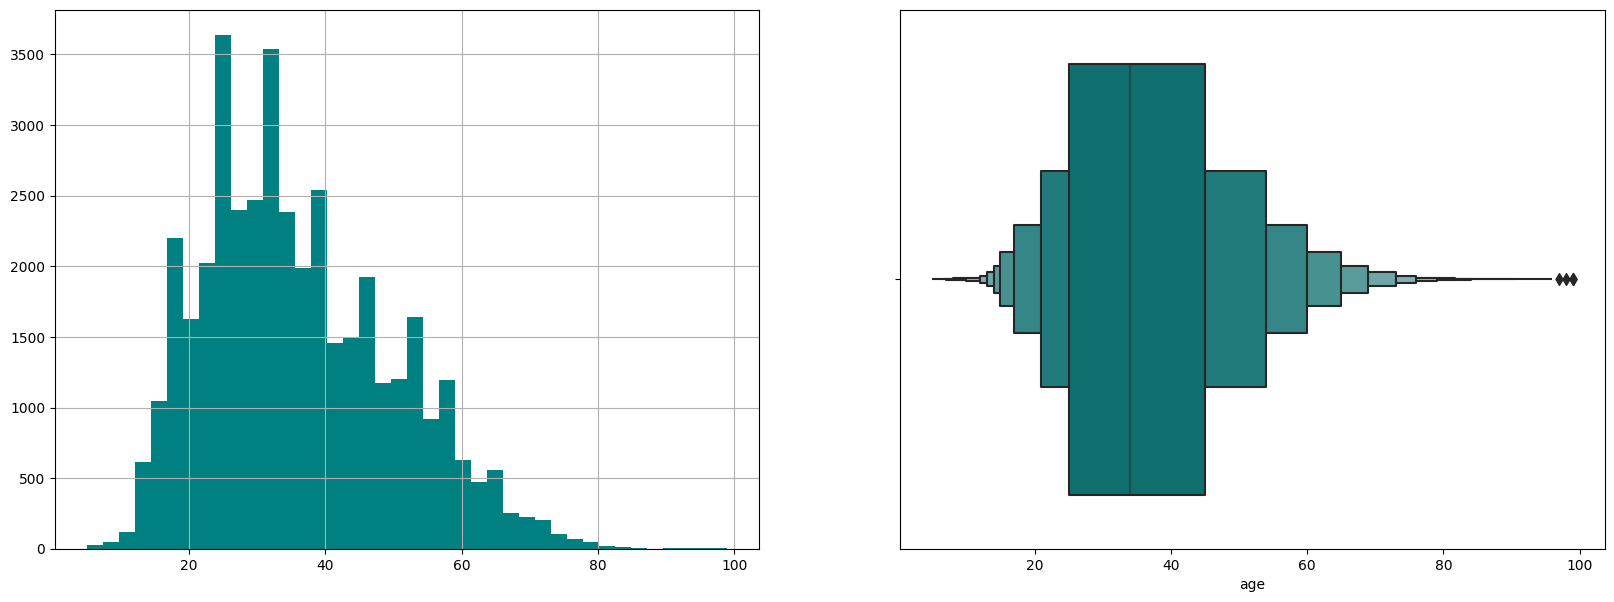

In [16]:
# 나이 분포
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

users['age'].hist(bins=40, color='teal', ax=ax[0])
sns.boxenplot(data=users, x='age', color='teal',ax=ax[1])

plt.show()

In [17]:
users['age'].value_counts()

age
29.0    1290
26.0    1250
25.0    1243
34.0    1215
27.0    1207
        ... 
86.0       1
94.0       1
89.0       1
98.0       1
92.0       1
Name: count, Length: 91, dtype: int64

In [18]:
users['age'].nunique()

91

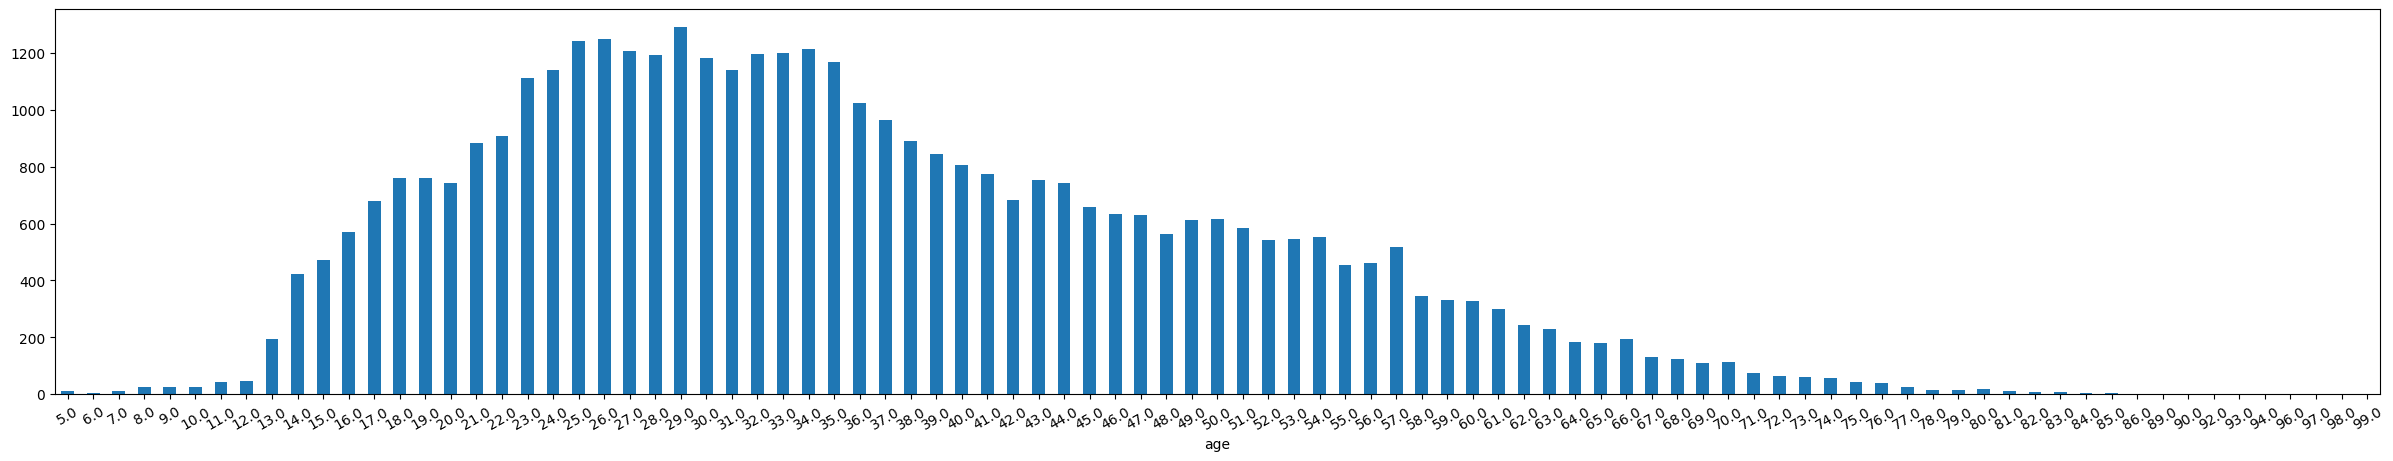

In [19]:
plt.figure(figsize=(30,5))
users['age'].value_counts().sort_index().plot(kind='bar')
plt.xticks(rotation=30)
plt.show()

20대 초반 ~ 30대 중반까지의 사용자가 많은 것을 확인할 수 있습니다.

이번에는 사용자들의 거주 국가를 살펴보고 국가별로 사용자의 분포가 다른지 알아보겠습니다.

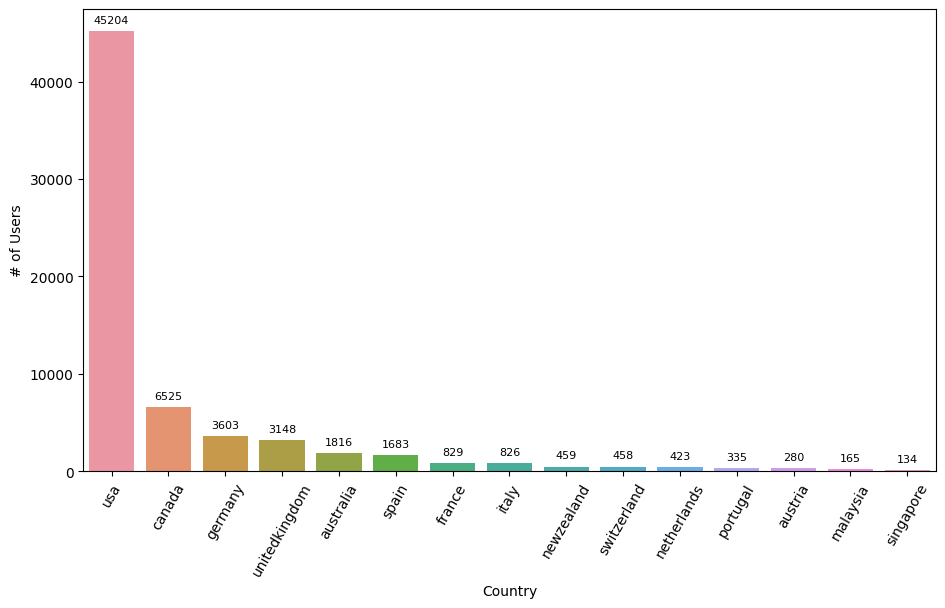

In [20]:
my_dict=(users['location_country'].value_counts()).to_dict()
count= pd.DataFrame(list(my_dict.items()),columns = ['location_country','count'])
f = count.sort_values(by=['count'], ascending = False)
f = f.head(15)
# f.drop(7,inplace=True)
fig=plt.figure(figsize=(11,6))
ax = sns.barplot(y = 'count',x= 'location_country' , data = f)
ax.set_xticklabels(ax.get_xticklabels(), rotation=60,horizontalalignment='center')
for bar in ax.patches: 
    ax.annotate(format(bar.get_height(), '.0f'),  
                   (bar.get_x() + bar.get_width() / 2,  
                    bar.get_height()), ha='center', va='center', 
                   size=8, xytext=(0,8), 
                   textcoords='offset points') 

plt.xlabel("Country", size=10)
plt.ylabel("# of Users", size=10)
plt.show()

사용자의 대다수는 미국에 거주중인 것을 확인할 수 있습니다.

국가별 사용자의 나이대를 알아보겠습니다.



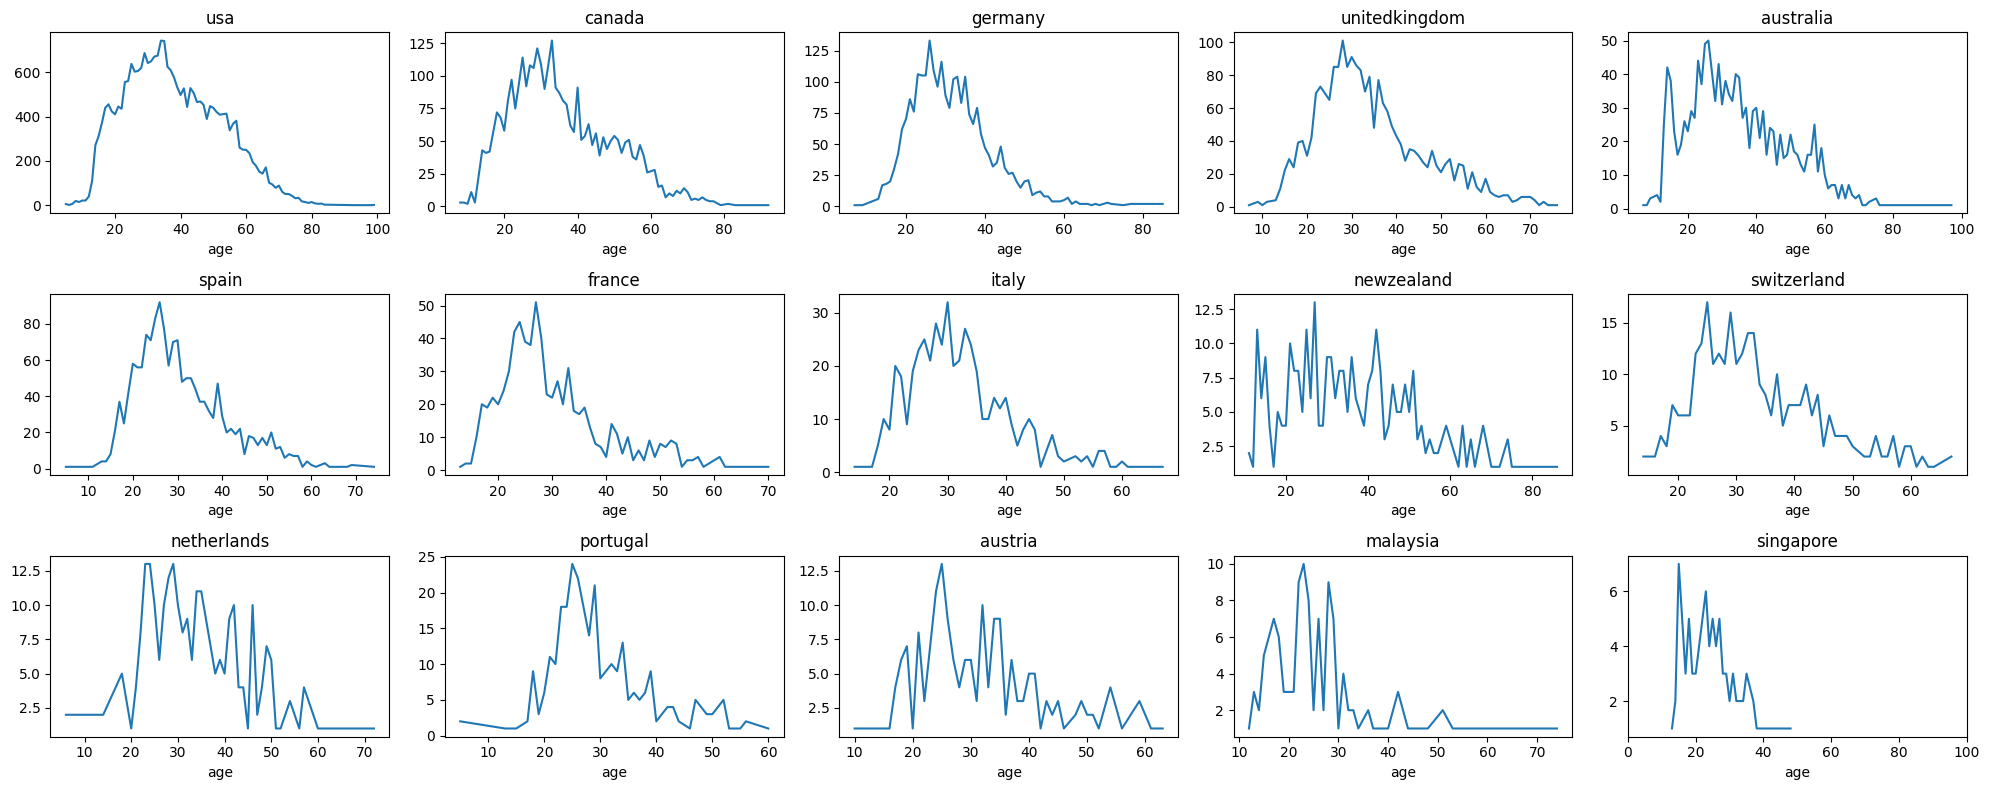

In [21]:
fig, ax = plt.subplots(3,5,figsize=(20,8))
for country, ax_ in zip(f['location_country'], ax.flatten()):
    users[(users['location_country']==country)]['age'].value_counts().sort_index().plot(ax=ax_, title=country)
plt.xlim(0,100)
plt.tight_layout()
plt.show()

대부분 20~30대 사용자가 많지만, 국가별로 사용자의 분포가 약간씩 차이가 있는 것을 확인할 수 있습니다.

age의 결측값을 살펴보겠습니다.

In [22]:
users[users['age'].isna()]['location_country'].value_counts()

location_country
usa                  20214
canada                3139
germany               1105
unitedkingdom          958
australia              477
                     ...  
unitedstaes              1
missouri                 1
unknown                  1
dominicanrepublic        1
macedonia                1
Name: count, Length: 177, dtype: int64

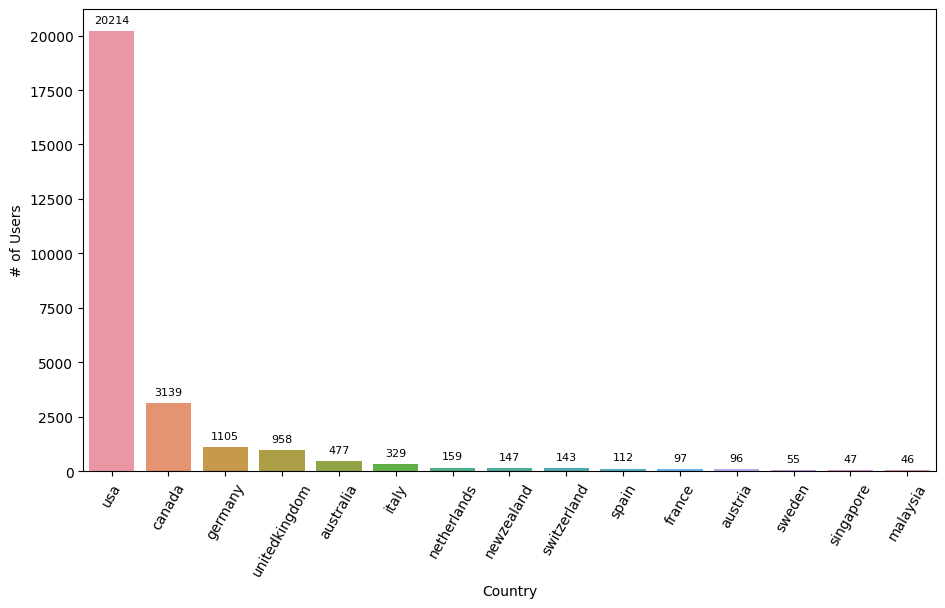

In [23]:
my_dict=(users[users['age'].isna()]['location_country'].value_counts()).to_dict() # age가 결측치인 사용자들의 국가 분포
count= pd.DataFrame(list(my_dict.items()),columns = ['location_country','count'])
f = count.sort_values(by=['count'], ascending = False)
f = f.head(15)
fig=plt.figure(figsize=(11,6))
ax = sns.barplot(y = 'count',x= 'location_country' , data = f)
ax.set_xticklabels(ax.get_xticklabels(), rotation=60,horizontalalignment='center')
for bar in ax.patches: 
    ax.annotate(format(bar.get_height(), '.0f'),  
                   (bar.get_x() + bar.get_width() / 2,  
                    bar.get_height()), ha='center', va='center', 
                   size=8, xytext=(0,8), 
                   textcoords='offset points') 

plt.xlabel("Country", size=10)
plt.ylabel("# of Users", size=10)
plt.show()

위의 그래프와 큰 차이가 없는 점을 고려했을때, 특정국가에 몰려있다기 보단 골고루 결측치가 퍼져 있다고 판단할 수 있습니다.

국가별 평균, 중앙값, 최빈값 등을 넣어볼수도 있고, 국가별로 큰 나이분포에 큰 차이가 없다고 판단한 경우 전체의 통계치로 채울 수도 있습니다.

또는 결측값을 평균, 중앙값, 최빈값 등의 값으로 채우지 않고 결측값 자체로 가져가는 방법도 있습니다. 

다양한 방법을 시도해보시기 바랍니다.

### 사용자들의 나이 결측값을 어떻게 채울 수 있을 것인가?
**1. 국가별 평균, 중앙, 최빈값**  
**2. 전체 평균, 중앙, 최빈값**  
**3. 결측치 자체로 가져가기**  

In [24]:
to_replace = users.groupby('location_country').agg({'age':'median'}).reset_index() # 국가별 중앙값으로 대체할 리스트 
age_dict = {country : age for _,(country,age) in to_replace.iterrows()}
for country in age_dict:
    users.loc[(users['age'].isna())&(users['location_country']== country),'age'] = age_dict[country]

In [25]:
users = users.drop(columns='location')

# [3] books
이제 책에 대한 정보를 살펴보겠습니다.

`isbn`, `book_title`, `book_author`, `year_of_publication`, `publisher`, `img_s', `img_m`, `img_l`, `language`, `category` 칼럼으로 이뤄져있습니다.

`isbn`은 책의 고유 코드를 나타냅니다

같은 title을 가진 책이더라도 발행 년도, 출판사, 언어 등에 따라 책 코드가 다를 수 있습니다.


In [26]:
books.shape

(149570, 10)

In [27]:
books['isbn'].nunique()

149570

In [28]:
books['book_title'].nunique()

135436

In [29]:
books.head()

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path
0,0002005018,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,en,['Actresses'],"In a small town in Canada, Clara Callan reluct...",images/0002005018.01.THUMBZZZ.jpg
1,0060973129,Decision in Normandy,Carlo D'Este,1991.0,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,en,['1940-1949'],"Here, for the first time in paperback, is an o...",images/0060973129.01.THUMBZZZ.jpg
2,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999.0,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,en,['Medical'],"Describes the great flu epidemic of 1918, an o...",images/0374157065.01.THUMBZZZ.jpg
3,0399135782,The Kitchen God's Wife,Amy Tan,1991.0,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,en,['Fiction'],A Chinese immigrant who is convinced she is dy...,images/0399135782.01.THUMBZZZ.jpg
4,0425176428,What If?: The World's Foremost Military Histor...,Robert Cowley,2000.0,Berkley Publishing Group,http://images.amazon.com/images/P/0425176428.0...,en,['History'],"Essays by respected military historians, inclu...",images/0425176428.01.THUMBZZZ.jpg


In [30]:
books.isna().sum() #language, category, summary에 결측값이 있습니다

isbn                       0
book_title                 0
book_author                1
year_of_publication        0
publisher                  0
img_url                    0
language               67227
category               68851
summary                67227
img_path                   0
dtype: int64

## (3-1) Preprocessing & Feature Engineering

books의 경우 데이터를 다양한 방법으로 수정하여 여러 테스트를 해볼 수 있을 것으로 예상됩니다.

본 미션의 내용 이외에 다양한 시도를 해보고 성능을 측정해보시기 바랍니다.



### (3-1-1) isbn

In [31]:
books.head()

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path
0,0002005018,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,en,['Actresses'],"In a small town in Canada, Clara Callan reluct...",images/0002005018.01.THUMBZZZ.jpg
1,0060973129,Decision in Normandy,Carlo D'Este,1991.0,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,en,['1940-1949'],"Here, for the first time in paperback, is an o...",images/0060973129.01.THUMBZZZ.jpg
2,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999.0,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,en,['Medical'],"Describes the great flu epidemic of 1918, an o...",images/0374157065.01.THUMBZZZ.jpg
3,0399135782,The Kitchen God's Wife,Amy Tan,1991.0,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,en,['Fiction'],A Chinese immigrant who is convinced she is dy...,images/0399135782.01.THUMBZZZ.jpg
4,0425176428,What If?: The World's Foremost Military Histor...,Robert Cowley,2000.0,Berkley Publishing Group,http://images.amazon.com/images/P/0425176428.0...,en,['History'],"Essays by respected military historians, inclu...",images/0425176428.01.THUMBZZZ.jpg



isbn은 책의 개별적인 고유번호를 나타내는 10자리 숫자입니다.

출판 국가, 출판사 번호, 항목 번호, 확인 숫자 순서로 구성되며 확인 숫자의 경우 10을 나타내는 X가 오기도 합니다.

이 번호를 활용하여 출판사의 항목 갯수를 줄여보도록 하겠습니다.

#### (1) isbn 활용하여 출판사의 항목 갯수 줄이기

In [32]:
publisher_dict=(books['publisher'].value_counts()).to_dict()
publisher_count_df= pd.DataFrame(list(publisher_dict.items()),columns = ['publisher','count'])

publisher_count_df = publisher_count_df.sort_values(by=['count'], ascending = False)

In [33]:
publisher_count_df.head()

,publisher,count
0,Harlequin,3005
1,Ballantine Books,2322
2,Pocket,2274
3,Penguin Books,1943
4,Bantam Books,1938


In [34]:
books['publisher'].nunique() # 수정전 항목 수를 확인합니다.

11571

In [35]:
modify_list = publisher_count_df[publisher_count_df['count']>1].publisher.values

In [36]:
for publisher in modify_list:
    try:
        number = books[books['publisher']==publisher]['isbn'].apply(lambda x: x[:4]).value_counts().index[0]
        right_publisher = books[books['isbn'].apply(lambda x: x[:4])==number]['publisher'].value_counts().index[0]
        books.loc[books[books['isbn'].apply(lambda x: x[:4])==number].index,'publisher'] = right_publisher
    except: 
        pass

In [37]:
books['publisher'].nunique() #수정 후 출판사 갯수입니다

1523

#### (2) isbn 활용하여 국가코드 만들기
[국가코드 참고 1](https://en.wikipedia.org/wiki/List_of_ISBN_registration_groups)    
[국가코드 참고 2](https://everything2.com/title/ISBN+Country+codes)

In [164]:
sorted(books['country_code'].unique())

['0', '1', '2', '3', '4', '5', '7', '8', '9', 'B']

In [170]:
def country_code(isbn:str):
    prefix_1 = ('0','1','2','3','4','5','7')
    prefix_2 = tuple(map(str,range(80,94)))
    prefix_3 = tuple(list(map(str,range(950,960)))+list(map(str,range(961,969)))+list(map(str,range(970,985)))+['986','987'])
    if isbn.startswith(prefix_1):
        return isbn[0]
    elif isbn.startswith(prefix_2):
        return isbn[:2]
    elif isbn.startswith(prefix_3):
        return isbn[:3]
    else:
        return np.NaN

books['final_country_code'] = books['isbn'].map(country_code)

In [181]:
books.shape[0] - sum(books['final_country_code'].value_counts())
# 국가코드 없는 거 106개 밖에 안되서 괜찮을 듯!

106

**시도한 것: isbn의 첫자리가 국가 코드라고 해서, 해당 국가에서는 그 나라의 언어만을 이용한다고 생각, 그래서 isbn의 첫자리를 따와서 language의 nan값을 채울 수 있을 것이라 생각**  
**결과: 나라를 기준으로 나눠놔서, 해당 나라에서 다른 나라의 언어로 출판된 출간물이 존재해서 채울 수 없을 것 같음**  
**그렇다면 나라 코드 자체로 의미가 있는 건 아닐까? -> isbn의 앞자리를 딴 feature 하나 만들어둠**  

### (3-1-2) Category

category를 칼럼의 항목을 대괄호 밖으로 빼는 과정을 거친 뒤 어떤 category가 있는지 살펴보겠습니다

In [125]:
import re
def category_preprocessing(category:str):
    category = re.sub("[^0-9a-zA-Z\\s]", " ", category) # 0-9,알파벳, 공백이 아닌것 제거 
    category = re.sub("\s+", " ", category)
    category = category.lower().strip() # 소문자/대문자 전처리
    return category

In [126]:
books.loc[books[books['category'].notnull()].index, 'category'] = books[books['category'].notnull()]['category'].map(category_preprocessing)

In [127]:
books['category'].unique()

array(['actresses', '1940 1949', 'medical', ..., 'deafness',
       'alternative histories',
       'authors canadian english 20th century biography'], dtype=object)

#### word2vec 시도

In [142]:
import gensim

# 1. unique한 카테고리에 대해 임베딩 형성
# 2. 해당 임베딩을 거기다가 매칭 
def word2vec(unique_category:np.array):
    word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)
    embedding_dict = dict()
    k = 300
    for category in unique_category:
        embedding = np.zeros(k,)
        try:
            words = category.split()
            for word in words:
                embedding += word2vec_model[category]
            embedding_dict[category] = embedding
        except:
            embedding_dict[category] = np.zeros(k,)
    return embedding_dict

In [143]:
embedding_dict = word2vec(books['category'].unique())
books['category_embedding'] = books['category'].map(embedding_dict)

In [144]:
books['category'].value_counts()

category
fiction                                            33016
juvenile fiction                                    5835
biography autobiography                             3326
history                                             1927
religion                                            1818
                                                   ...  
brenner simon fictitious character                     1
gone with the wind motion picture 1939                 1
disguise                                               1
country lawyers                                        1
authors canadian english 20th century biography        1
Name: count, Length: 4105, dtype: int64

In [145]:
category_df = pd.DataFrame(books['category_embedding'].value_counts()).reset_index()
category_df.columns = ['category','count']

### isbn2vec 시도

In [ ]:
from typing import Union, Tuple, List

import os
import numpy as np
import random
import pandas as pd
from datetime import datetime, date
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score, precision_score, recall_score
from tqdm import tqdm

import matplotlib.pyplot as plt
# import seaborn as sns
%matplotlib inline

# from IPython.display import Image

import torch
import torch.nn as nn
from torch.nn.init import normal_
from torch.utils.data import TensorDataset, DataLoader

In [184]:
books

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path,country_code,final_category,category_embedding,final_country_code
0,0002005018,Clara Callan,Richard Bruce Wright,2001.0,Collins,http://images.amazon.com/images/P/0002005018.0...,en,actresses,"In a small town in Canada, Clara Callan reluct...",images/0002005018.01.THUMBZZZ.jpg,0,brothers,"[-0.1640625, -0.06298828125, -0.03125, 0.07910...",0
1,0060973129,Decision in Normandy,Carlo D'Este,1991.0,Perennial,http://images.amazon.com/images/P/0060973129.0...,en,1940 1949,"Here, for the first time in paperback, is an o...",images/0060973129.01.THUMBZZZ.jpg,0,1940 1949,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
2,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999.0,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,en,medical,"Describes the great flu epidemic of 1918, an o...",images/0374157065.01.THUMBZZZ.jpg,0,geschichte,"[-0.1376953125, 0.1484375, -0.01544189453125, ...",0
3,0399135782,The Kitchen God's Wife,Amy Tan,1991.0,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,en,fiction,A Chinese immigrant who is convinced she is dy...,images/0399135782.01.THUMBZZZ.jpg,0,nonfiction,"[-0.007568359375, -0.265625, 0.00885009765625,...",0
4,0425176428,What If?: The World's Foremost Military Histor...,Robert Cowley,2000.0,Berkley Publishing Group,http://images.amazon.com/images/P/0425176428.0...,en,history,"Essays by respected military historians, inclu...",images/0425176428.01.THUMBZZZ.jpg,0,histoire,"[0.09619140625, 0.1357421875, 0.1357421875, 0....",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149565,067161746X,The Bachelor Home Companion: A Practical Guide...,P.J. O'Rourke,1987.0,Pocket,http://images.amazon.com/images/P/067161746X.0...,en,humor,A tongue-in-cheek survival guide for single pe...,images/067161746X.01.THUMBZZZ.jpg,0,fathers,"[0.43359375, -0.08544921875, 0.09912109375, 0....",0
149566,0767907566,All Elevations Unknown: An Adventure in the He...,Sam Lightner,2001.0,Broadway Books,http://images.amazon.com/images/P/0767907566.0...,en,nature,A daring twist on the travel-adventure genre t...,images/0767907566.01.THUMBZZZ.jpg,0,service,"[0.138671875, 0.2041015625, 0.0289306640625, 0...",0
149567,0884159221,Why stop?: A guide to Texas historical roadsid...,Claude Dooley,1985.0,Bridge Publications,http://images.amazon.com/images/P/0884159221.0...,NaN,NaN,NaN,images/0884159221.01.THUMBZZZ.jpg,0,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
149568,0912333022,The Are You Being Served? Stories: 'Camping In...,Jeremy Lloyd,1997.0,Pub Group West,http://images.amazon.com/images/P/0912333022.0...,en,fiction,These hilarious stories by the creator of publ...,images/0912333022.01.THUMBZZZ.jpg,0,nonfiction,"[-0.007568359375, -0.265625, 0.00885009765625,...",0


In [185]:
ratings.head()

,user_id,isbn,rating
0,8,0002005018,4
1,67544,0002005018,7
2,123629,0002005018,8
3,200273,0002005018,8
4,210926,0002005018,9


In [189]:
# 유저가 평가한 카테고리를 문장으로, 개별 카테고리를 단어로 가정하여 word2vec 사용
positive_samples = ratings.copy()
# positive_samples = positive_samples[positive_samples['ratings'] == 1]
# positive_samples = positive_samples[['user_id', 'movie_id', 'liked']]

In [190]:
# 단어가 최소 3회 이상 등장해야 학습되고 모델에 저장됨
min_count = 3
# 1개의 positive sample당 negative sample의 개수
negative = 5

In [ ]:
isbns_for_training = list()
for isbn in ratings['isbn'].unique():
    if positive_samples[positive_samples['isbn'] == isbn].shape[0] >= min_count:
        isbns_for_training.append(isbn)

In [ ]:
new_positive_samples = dict()
new_positive_samples['user_id'] = list()
new_positive_samples['w_isbn_id'] = list()
new_positive_samples['c_isbn_id'] = list()

user_negative_samples = dict()

isbn_ids = ratings['isbn'].unique()

for user_id in tqdm(ratings['user_id'].unique()):
    user_positive_samples = positive_samples[positive_samples['user_id'] == user_id]
    user_isbns = user_positive_samples['isbn'].tolist()
    # sampling을 위해 각 user id의 negative ratings를 저장
    user_neg_isbns = [isbn_id for isbn_id in isbn_ids if isbn not in user_isbns]
    user_negative_samples[user_id] = np.array(user_neg_isbns)
    for w_isbn_id in user_isbns:
        # 단어가 최소 등장 횟수를 만족하지 않음
        if w_isbn_id not in isbns_for_training:
            continue
        for c_isbn_id in user_isbns:
            if c_isbn_id == w_isbn_id:
                continue
            new_positive_samples['user_id'].append(user_id)
            new_positive_samples['w_isbn_id'].append(w_isbn_id)
            new_positive_samples['c_isbn_id'].append(c_isbn_id)

new_positive_samples = pd.DataFrame(new_positive_samples)

In [ ]:
for user_id in user_negative_samples:
    user_negative_samples[user_id] = np.array(user_negative_samples[user_id])

In [ ]:
new_positive_samples['user_id'] = new_positive_samples['user_id'].astype("category")
new_positive_samples['w_isbn_id'] = new_positive_samples['w_isbn_id'].astype("category")
new_positive_samples['c_isbn_id'] = new_positive_samples['c_isbn_id'].astype("category")
train_df, test_df = train_test_split(
    new_positive_samples, stratify=new_positive_samples['user_id'], random_state=seed, test_size=0.20
)
print('학습 데이터 크기:', train_df.shape)
print('테스트 데이터 크기:', test_df.shape)

In [ ]:
# PyTorch의 DataLoader에서 사용할 수 있도록 변환 
train_dataset = TensorDataset(torch.LongTensor(np.array(train_df)))
test_dataset = TensorDataset(torch.LongTensor(np.array(test_df)))

In [ ]:
class Negative_Sampler(nn.Module):
    """
    Negative Sampler
    
    Args:
        - user_negative_samples: (Dict) keys: user id, items: list of negative samples
        - n_negs: (int) negative sample의 수
    Shape:
        - Input: (torch.Tensor) user id들, (user id, 중심 item id, 주변 item id). Shape: (batch size,)
        - Output: (torch.Tensor) sampling된 negative samples. Shape: (batch size, n_negs)
    """
    def __init__(self, user_negative_samples, n_negs):
        super(Negative_Sampler, self).__init__()
        self.user_negative_samples = user_negative_samples
        self.n_negs = n_negs
    
    def forward(self, user_ids):
        user_ids = user_ids.to('cpu').numpy()
        negative_samples = np.array([
            np.random.choice(self.user_negative_samples[user_id],self.n_negs,replace=False)
            for user_id in user_ids
        ])
        return torch.from_numpy(negative_samples)
    

In [ ]:
class SGNS(nn.Module):
    """
    Skip-Gram with Negative Sampling
    
    Args:
        - n_items: (int) 전체 아이템의 수
        - emb_dim: (int) Embedding의 Dimension
        - user_negative_samples: (Dict) user id 별 전체 negative sample
        - n_negs: (int) negative sample의 수
    Shape:
        - Input: (torch.Tensor) input features, (user id, 중심 item id, 주변 item id). Shape: (batch size, 3)
        - Output: (torch.Tensor) sampling된 negative samples와 positive sample의 Loss 합. Shape: ()
    """
    def __init__(self, n_items, emb_dim, user_negative_samples, n_negs):
        super(SGNS, self).__init__()
        
        # initialize Class attributes
        self.n_items = n_items
        self.emb_dim = emb_dim
        self.user_negative_samples = user_negative_samples
        self.n_negs = n_negs
        self.negative_sampler = Negative_Sampler(self.user_negative_samples, self.n_negs)
        
        # define embeddings
        # 중심 아이템
        self.w_item_embedding =  nn.Embedding(self.n_items,self.emb_dim)
        # 주변 아이템
        self.c_item_embedding =  nn.Embedding(self.n_items,self.emb_dim)
        self.sigmoid = nn.Sigmoid()
        
        self.loss_fn = nn.BCELoss()
        
        self.apply(self._init_weights)
        
    # initialize weights
    def _init_weights(self, module):
        if isinstance(module, nn.Embedding):
            normal_(module.weight.data, mean=0.0, std=0.01)
    
    def forward(self, input_feature):
        batch_size = input_feature.size()[0]
        
        user_ids, w_item, c_item = torch.split(input_feature, [1, 1, 1], -1)
        # 유저 id
        user_ids = user_ids.squeeze(-1)
        # 중심 아이템
        w_item = w_item.squeeze(-1)
        # 주변 아이템 (positive sample)
        c_item = c_item.squeeze(-1)
        # 주변 아이템 negative sampling
        neg_c_items = self.negative_sampler(user_ids)
        
        # 중심 아이템 embedding
        w_item_e =  self.w_item_embedding(w_item) 
        # 주변 아이템 (positive sample) embedding
        c_item_e =  self.c_item_embedding(c_item)
        # 주변 아이템 (negative sample) embedding
        neg_c_items_e =  self.c_item_embedding(neg_c_items) 
        # HINT: neg_c_items_e.shape == (batch_size, self.n_negs, self.emb_dim)
        
        w_item_e = w_item_e.view(batch_size, 1, self.emb_dim)
        c_item_e = c_item_e.view(batch_size, self.emb_dim, 1)
        neg_c_items_e = neg_c_items_e.permute(0, 2, 1)
        
        pos_output = torch.bmm(w_item_e,c_item_e) 
        pos_output = pos_output.squeeze(-1)
        pos_output = self.sigmoid(pos_output).squeeze(-1)

        
        pos_y = torch.ones(pos_output.size())
        pos_loss = self.loss_fn(pos_output, pos_y)
        
        neg_output = torch.bmm(w_item_e,neg_c_items_e) 
        neg_output = neg_output.squeeze(-1)
        neg_output = self.sigmoid(neg_output)
        
        neg_y = torch.zeros(neg_output.size())
        neg_loss = self.loss_fn(neg_output, neg_y)

        
        
        return pos_loss + neg_loss


In [ ]:
# Reference - https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

def train_loop(dataloader, model, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss = 0
    
    for batch, (X,) in enumerate(dataloader):
        X = X.to(device)
        # Compute prediction and loss
        loss = model(X)
        train_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        if (batch+1) % 100 == 0:
            loss, current = loss.item(), (batch+1) * len(X)
            print(f"Loss: {loss:>7f} | [{current:>5d}/{size:>5d}]")
    train_loss /= num_batches
    
    return train_loss


def test_loop(dataloader, model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss= 0
    
    with torch.no_grad():
        for X, in dataloader:
            X= X.to(device)
            loss = model(X)
            test_loss += loss.item()
    test_loss /= num_batches
    print(f"Test Error:\n\tAvg Loss: {test_loss:>8f}")
    return test_loss


In [ ]:
def train_and_test(train_dataloader, test_dataloader, model, optimizer, epochs):
    train_loss, test_loss = list(), list()

    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_result= train_loop(train_dataloader, model, optimizer)
        train_loss.append(train_result)
        test_result = test_loop(test_dataloader, model)
        test_loss.append(test_result)
        print("-------------------------------\n")
    print("Done!")

    return train_loss, test_loss


In [ ]:
######## Hyperparameter ########

batch_size = 2048
data_shuffle = True
emb_dim = 512
epochs = 5
learning_rate = 0.001
gpu_idx = 0

n_items = ratings_df['movie_id'].nunique()

################################
# torch.cuda.empty_cache() # if necessary
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

device = torch.device("cuda:{}".format(gpu_idx) if torch.cuda.is_available() else "cpu")

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=data_shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=data_shuffle)

model = SGNS(n_items, emb_dim, user_negative_samples, negative).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, amsgrad=True)

In [ ]:
train_loss, test_loss = train_and_test(train_dataloader, test_dataloader, model, optimizer, epochs)

카테고리를 보면 3000개가 넘는 종류를 갖고 있습니다.

그러나 이 중 10개 이상의 중복을 갖는 카테고리가 50개가 안되는것을 통해, 많은 카테고리가 그룹화 안된 채로 존재한다고 볼 수 있습니다.

또한 일부 카테고리의 경우 전기&자서전 카테고리와 전기, 자서전 이렇게 나눠져 있는 경우가 있습니다. 

이러한 카테고리를 좀더 큰 카테고리로 묶어주는 과정을 시도하여 카테고리의 가짓수를 줄일 수 있습니다.

본 과정은 여러분들이 EDA를 진행하는 과정에서 더 많은 시도를 해볼 수 있을 것으로 생각됩니다.


상위 카테고리를 만들어보겠습니다.

In [ ]:
books['category_high'] = books['category'].copy()
books.loc[books[books['category']=='biography'].index, 'category_high'] = 'biography autobiography'
books.loc[books[books['category']=='autobiography'].index,'category_high'] = 'biography autobiography'

하나씩 찾아서 변경하기엔 너무 많은 자료양을 갖고 있습니다. 

따라서 이런식으로 해당 단어를 포함하는 경우 전체를 바꿀 수 있습니다.

In [121]:
books[books['category'].str.contains('history', na=False)]['category'].unique()

array(['history', 'oral history', 'natural history', 'history modern',
       'world history', 'politics history 1945', 'history asia',
       'church history', 'constitutional history'], dtype=object)

In [ ]:
books.loc[books[books['category'].str.contains('history',na=False)].index,'category_high'] = 'history'

이렇게 바꾸기에도 방대한 양을 가지고 있으므로 반복문을 통해 몇가지 카테고리들을 처리하는 예시를 보여드리겠습니다.

In [122]:
categories = ['garden','crafts','physics','adventure','music','fiction','nonfiction','science','science fiction','social','homicide',
 'sociology','disease','religion','christian','philosophy','psycholog','mathemat','agricult','environmental',
 'business','poetry','drama','literary','travel','motion picture','children','cook','literature','electronic',
 'humor','animal','bird','photograph','computer','house','ecology','family','architect','camp','criminal','language','india']

for category in categories:
    books.loc[books[books['category'].str.contains(category,na=False)].index,'category_high'] = category

In [123]:
category_high_df = pd.DataFrame(books['category_high'].value_counts()).reset_index()
category_high_df.columns = ['category','count']
category_high_df.head(10)

,category,count
0,fiction,39678
1,religion,1824
2,nonfiction,1427
3,humor,1291
4,social,1271
5,business,1146
6,cook,1125
7,science,1063
8,family,988
9,literary,848


In [124]:
# 5개 이하인 항목은 others로 묶어주도록 하겠습니다.
others_list = category_high_df[category_high_df['count']<5]['category'].values

In [125]:
books.loc[books[books['category_high'].isin(others_list)].index, 'category_high']='others'

In [126]:
books['category'].nunique()

4105

In [127]:
books['category_high'].nunique()

43

이런식으로 category 가지수를 줄일 수 있습니다.

데이터를 살펴보다 보면 아래처럼 같은 책으로 여겨지는 항목이 있는 경우가 있습니다.

그러나 책의 고유 번호인 isbn이 다르고, 출판사가 다르므로 설령 같은 책이여도, 다른 국가에서 출판됐을 가능성을 배재할 수 없으므로 language를 채우는 것은 어려워보입니다.

물론, 0446365505 책의 category_high를 fiction으로 수정하는 작업은 해볼 수 있습니다.

뒤의 작업들을 해보면서 category 항목이 중요하다고 여겨지면, 좀더 시간을 들여서 상위 카테고리 지정하여 데이터 전처리 수준을 올릴 수 있을 것입니다.

### 제목과 작가가 같은데 ISBN이 다르다면,category high를 통해 카테고리 항목 결측치 채울수도!

In [197]:
books[books['book_title'].str.startswith("Pleading")]

5041     False
22680    False
37056     True
Name: category, dtype: bool

## (3-2) 시각화

In [137]:
books['publisher'].value_counts().head(10)

publisher
Pocket                7306
Harlequin             5268
Bantam Books          4815
St. Martin's Press    4043
Vintage Books USA     3822
Penguin Books         3807
Perennial             3313
Ballantine Books      3090
Signet Book           3068
Avon                  2792
Name: count, dtype: int64

1376~2006년까지 출간된 책이 존재하고 있습니다.

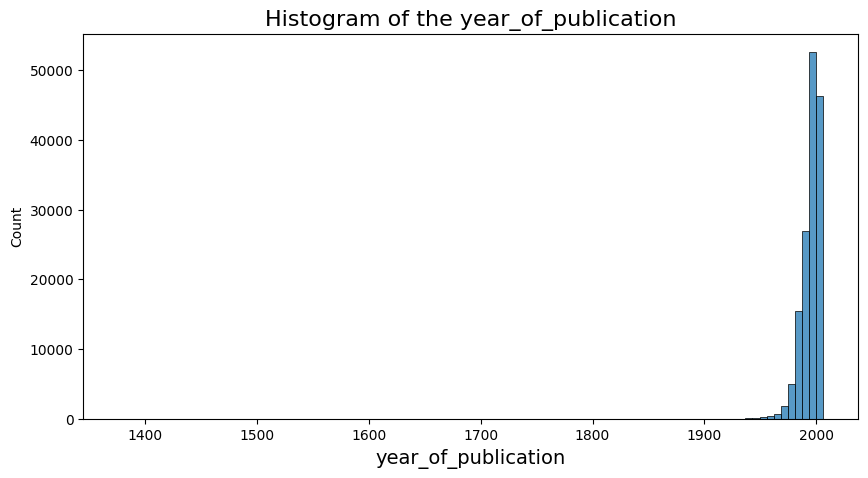

In [140]:
plt.figure(figsize=(10,5))
sns.histplot(books['year_of_publication'],bins=100)
plt.xlabel('year_of_publication',size=14)
plt.title('Histogram of the year_of_publication',size=16)
plt.show()

### year_of_publication 분포가 왜도 > 0 -> 어떻게 처리할 것인가? 
- categorical로 만든다고 하면, 어떻게 묶어야할까?
- 데이터가 얼마 없는 구간 하나로 묶고, 2000년대 이후는 1년 단위로 처리하는 게 괜찮은 처리일까?

In [141]:
books['year_of_publication'].value_counts().sort_index()

year_of_publication
1376.0        1
1378.0        1
1806.0        1
1900.0        1
1901.0        4
          ...  
2002.0    11669
2003.0     9430
2004.0     3771
2005.0       19
2006.0        1
Name: count, Length: 95, dtype: int64

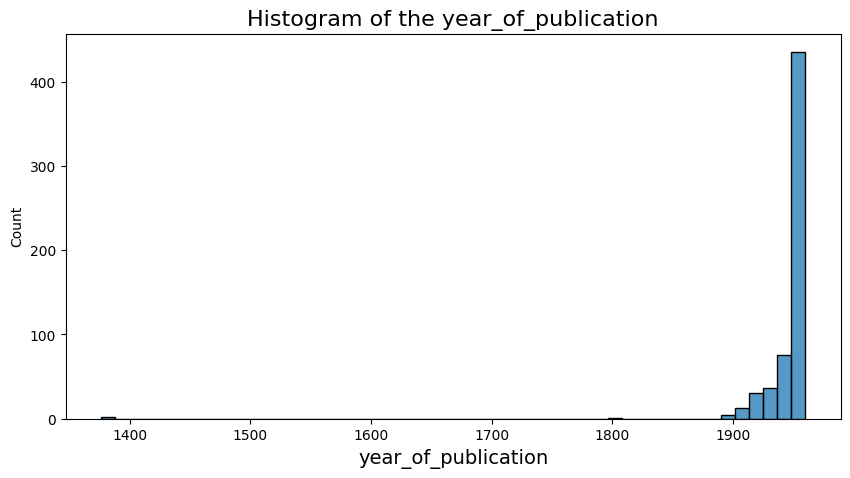

In [145]:
plt.figure(figsize=(10,5))
sns.histplot(books[books['year_of_publication']<=1960]['year_of_publication'],bins=50)
plt.xlabel('year_of_publication',size=14)
plt.title('Histogram of the year_of_publication',size=16)
plt.show()

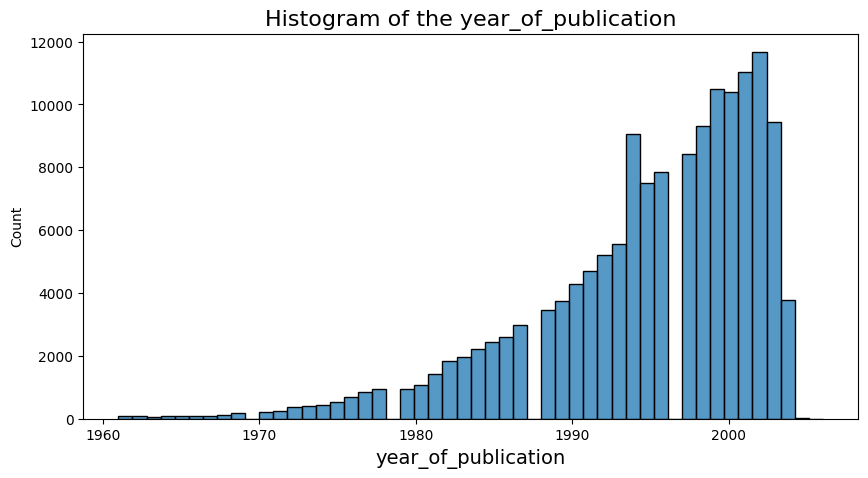

In [148]:
plt.figure(figsize=(10,5))
sns.histplot(books[books['year_of_publication']>1960]['year_of_publication'],bins=50)
plt.xlabel('year_of_publication',size=14)
plt.title('Histogram of the year_of_publication',size=16)
plt.show()

1970년 이전의 책은 몇권 없는 것을 확인할 수 있습니다.

데이터의 책들은 1990년 이후의 책이 대다수입니다.

# [4] ratings

ratings 파일은 사용자가 특정 책을 읽고 점수를 매긴 데이터 입니다.

 `user_id`, `isbn`, `rating` 으로 이뤄져있습니다.

 한 사용자가 다른 책을 여러번 읽기 때문에 중복된 값이 나타나게 되지만,
 
 users에 있는 모든 사용자가 포함된 데이터입니다.

In [149]:
ratings.head()

,user_id,isbn,rating
0,8,0002005018,4
1,67544,0002005018,7
2,123629,0002005018,8
3,200273,0002005018,8
4,210926,0002005018,9


In [150]:
ratings['user_id'].nunique()

59803

In [151]:
ratings.shape

(306795, 3)

In [152]:
ratings['rating'].value_counts(True)

rating
8     0.239877
7     0.172519
9     0.158650
10    0.139422
6     0.082501
5     0.045995
1     0.043185
2     0.042142
4     0.041419
3     0.034290
Name: proportion, dtype: float64

rating은 1~10값을 가지며 8이 가장 많습니다.

총 59803명의 사용자들이 평가한 정보가 있습니다.

In [200]:
users.loc[users['user_id']=='','age']

,user_id,age,location_city,location_state,location_country
0,8,33.0,timmins,ontario,canada
1,11400,49.0,ottawa,ontario,canada
2,11676,NaN,NaN,NaN,NaN
3,67544,30.0,toronto,ontario,canada
4,85526,36.0,victoria,britishcolumbia,canada
...,...,...,...,...,...
68087,278376,54.0,danville,california,usa
68088,278621,74.0,victoria,delaware,canada
68089,278636,36.0,irvington,alabama,usa
68090,278659,33.0,vancouver,britishcolumbia,canada


## (4-1) 시각화

In [153]:
#유저당 몇 권 정도의 책을 읽었는지 살펴보겠습니다.
ratings.groupby('user_id')['rating'].count().sort_values(ascending=False)

user_id
11676     5520
98391     4560
189835    1503
153662    1496
23902      956
          ... 
47317        1
150670       1
150676       1
150677       1
138957       1
Name: rating, Length: 59803, dtype: int64

유저는 1권에서 5520권까지 책을 읽은 것으로 보입니다.
특히 두 유저만 4000권 이상의 많은 책을 읽었습니다.

많은 책을 읽은 유저들의 rating 분포와 그렇지 않은 유저들의 분포를 살펴보겠습니다.

In [154]:
heavy_users_list = ratings.groupby('user_id')['rating'].count().sort_values(ascending=False).head(20).index

In [155]:
ratings[ratings['user_id'].isin(heavy_users_list)].groupby('user_id')['rating'].mean()

user_id
11676     6.779891
16795     6.423684
23902     7.174686
35859     7.175896
56399     9.312036
76499     8.477778
95359     7.200820
98391     8.566228
101851    8.420354
114368    4.364389
153662    8.209893
158295    5.770270
171118    6.961089
177458    6.757794
182085    8.210269
185233    3.263914
189835    3.184298
197659    8.116170
235105    7.713054
248718    7.419009
Name: rating, dtype: float64

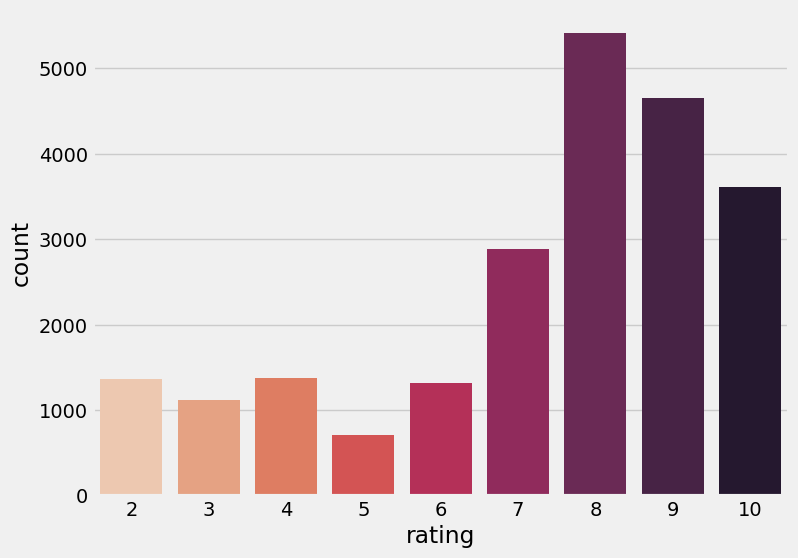

In [157]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(8, 6))
sns.countplot(data=ratings[(ratings['user_id'].isin(heavy_users_list))&(ratings['rating']>1)] , x='rating', palette='rocket_r')
plt.show()

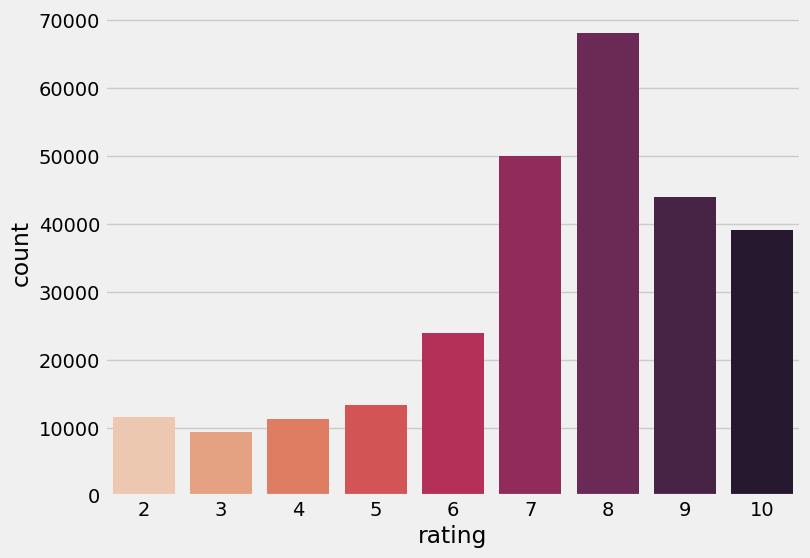

In [158]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(8, 6))
sns.countplot(data=ratings[~(ratings['user_id'].isin(heavy_users_list))&(ratings['rating']>1)] , x='rating', palette='rocket_r')
plt.show()

이번에는 가장 인기 있는 책은 몇번 읽혔는지 알아보겠습니다.

In [159]:
ratings.groupby('isbn')['rating'].count().sort_values(ascending=False)

isbn
0316666343    566
0971880107    465
0385504209    390
0312195516    307
0060928336    256
             ... 
0520060199      1
0520059808      1
0520058852      1
0520058763      1
B000234N3A      1
Name: rating, Length: 129777, dtype: int64

가장 인기있는 책은 566번 읽혔습니다. 

데이터 merge 이후 해당 책이 무엇인지 알아보겠습니다.

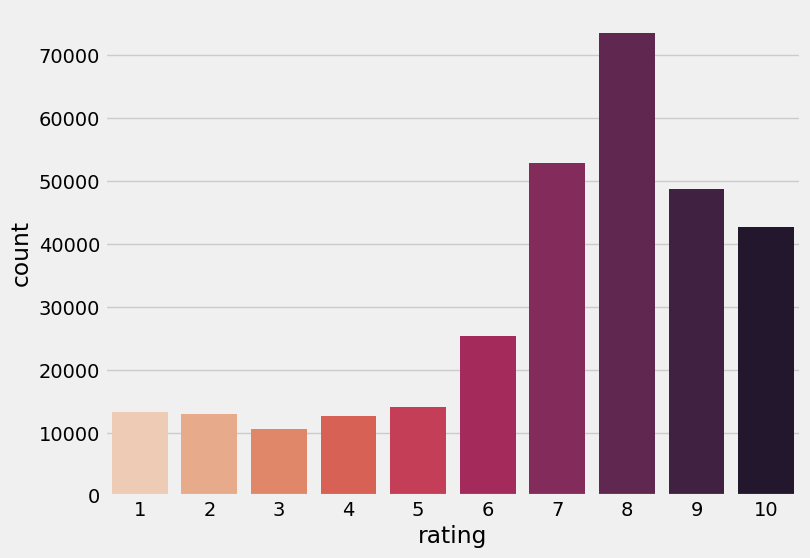

In [161]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(8, 6))
sns.countplot(data=ratings , x='rating', palette='rocket_r')
plt.show()

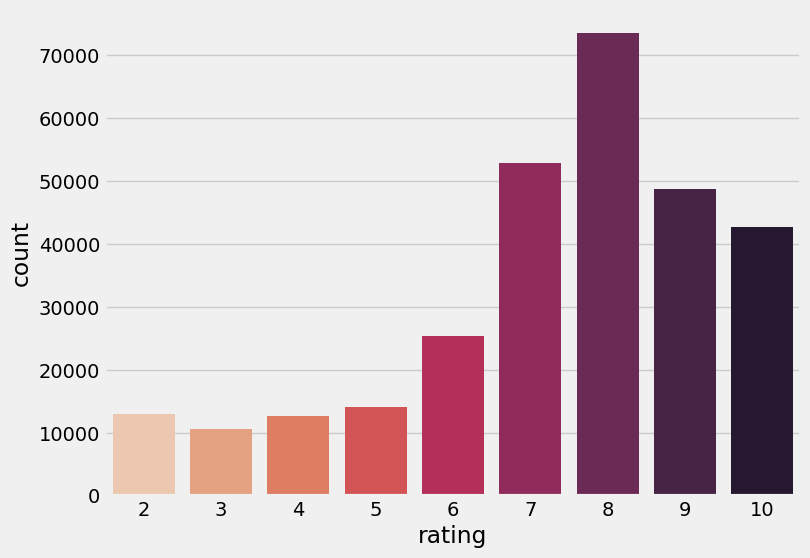

In [162]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(8, 6))
sns.countplot(data=ratings[(ratings['rating']>1)] , x='rating', palette='rocket_r')
plt.show()

# [5] 파일 merge

이제 세 파일을 모두 합쳐서 컬럼간의 관계를 살펴보도록 하겠습니다.

In [163]:
merge1 = ratings.merge(books, how='left', on='isbn') # ratings 목록에 없는 책들 삭제
data = merge1.merge(users, how='inner', on='user_id') # 평점에도 존재하는 user_id 기준으로 병합
print('merge 결과 shape: ', data.shape)

merge 결과 shape:  (306795, 17)


In [164]:
ratings.shape
# ratings 기록 갯수만큼 결과가 나온것을 확인 할 수 있습니다.

(306795, 3)

In [165]:
set(ratings['isbn']) - set(books['isbn']) 

set()

## (5-1) EDA 이후 진행방향

In [195]:
train_user_id = set(ratings['user_id'].unique())
train_isbn = set(ratings['isbn'].unique())

test_ratings = pd.read_csv(path+'test_ratings.csv')
test_user_id = set(test_ratings['user_id'].unique())
test_isbn = set(test_ratings['isbn'].unique())

total_user_id = set(users['user_id'].unique())
total_isbn = set(books['isbn'].unique())

In [190]:
# case 1.test에는 있는데 Train에는 없는 user_id: 해당 책이 다른 사용자에게 평점을 받은 case로 해결 
# 책 정보만을 고려한 평점 예측 
# 해당 유저가 users에는 존재한다면 users의 feature를 사용해서 예측?
# 해당 책에 대해 다른 유저가 내린 평점 이용 (산술평균)?
test_ratings[~test_ratings['user_id'].isin(train_user_id) & test_ratings['isbn'].isin(train_isbn)]

,user_id,isbn,rating
8,263256,1558746218,0
11,12923,0440234743,0
22,116127,0440234743,0
24,128463,0440234743,0
25,131703,0440234743,0
...,...,...,...
75802,261925,2290327654,0
75863,270752,0375500561,0
76041,262690,3442436885,0
76246,271029,0732710561,0


In [191]:
# case 2. test에는 있는데 Train에는 없는 isbn
# 유저의 정보만을 고려한 평점 예측
# 해당 책이 books에는 존재한다면 books의 feature 사용해서 예측
# 해당 유저가 다른 책에 내린 평점 이용
test_ratings[test_ratings['user_id'].isin(train_user_id) & ~test_ratings['isbn'].isin(train_isbn)]

,user_id,isbn,rating
7,11676,0671870432,0
64,14,0689821166,0
420,53,0245542957,0
538,87,0375509038,0
957,98391,0505524996,0
...,...,...,...
76694,278543,1576734218,0
76695,278563,3492223710,0
76696,278633,1896095186,0
76697,278668,8408044079,0


In [192]:
# case 3. 둘다 없어? 어쩌지..?
# Books, Users만 가지고 모델링 
train_user_id = set(train_ratings['user_id'].unique())
train_isbn = set(train_ratings['isbn'].unique())
test_ratings[test_ratings['user_id'].isin(train_user_id) | test_ratings['isbn'].isin(train_isbn)]

,user_id,isbn,rating
929,176,1900850303,0
953,190,0002740230,0
3491,278,0590431110,0
5123,530,0516076272,0
5998,705,8806142267,0
...,...,...,...
76612,275828,0802138748,0
76623,276067,0694004162,0
76655,277079,3499263998,0
76669,277514,3453042476,0


In [3]:
train_user_id = set(train_ratings['user_id'].unique())
train_isbn = set(train_ratings['isbn'].unique())
test_ratings[test_ratings['user_id'].isin(train_user_id)& test_ratings['isbn'].isin(train_isbn)]

,user_id,isbn,rating
0,11676,0002005018,0
1,116866,0002005018,0
2,152827,0060973129,0
3,157969,0374157065,0
4,67958,0399135782,0
...,...,...,...
76040,260897,0393956237,0
76046,262998,0140430466,0
76151,271538,0688061133,0
76194,269566,042510351X,0


In [11]:
test_ratings_filtered = test_ratings[test_ratings['user_id'].isin(train_user_id)& test_ratings['isbn'].isin(train_isbn)]

In [12]:
test_filtered_user_id = set(test_ratings_filtered['user_id'].unique())

In [13]:
len(test_filtered_user_id)/ len(test_user_id)

0.5921198456070623

In [ ]:
train_user_id = set(train_ratings['user_id'].unique())
train_isbn = set(train_ratings['isbn'].unique())
test_ratings[test_ratings['user_id'].isin(train_user_id)& test_ratings['isbn'].isin(train_isbn)]

In [15]:
train_ratings

,user_id,isbn,rating
0,8,0002005018,4
1,67544,0002005018,7
2,123629,0002005018,8
3,200273,0002005018,8
4,210926,0002005018,9
...,...,...,...
306790,278843,0743525493,7
306791,278851,067161746X,6
306792,278851,0884159221,7
306793,278851,0912333022,7


In [14]:
train_author = set(b['book_author'].unique())

KeyError: 'book_author'

In [4]:
train_user_id = set(train_ratings['user_id'].unique())
train_isbn = set(train_ratings['isbn'].unique())

test_ratings = pd.read_csv(path+'test_ratings.csv')
test_user_id = set(test_ratings['user_id'].unique())
test_isbn = set(test_ratings['isbn'].unique())

total_user_id = set(users['user_id'].unique())
total_isbn = set(books['isbn'].unique())

# !시도해볼것!

# EDA
## users.df
1. country로 바꿔도 다양한 형태로 결측치 존재
    - 정규표현식 수정
    - city만 존재한다면 같은 city를 지닌 데이터 중에 state와 country가 존재하는 데이터로 결측치 메울 수 있다!
2. 뉴질랜드, 네덜란드, 오스트레일리아 나이분포 형태 다름 -> 어떻게 해볼수 없을까? 나눠서? : 결측치 40퍼 넘어가는데 버려버릴까? 
3. 나이 결측치가 너무 많음 -> 어떻게 처리하는 게 좋을까?  

## books.df
1. cateogory 관련 부분
    - 처음에 우리 데이터로 word2vec 학습해서 사용하려고 했으나 문장 단위가 아니여서 학습이 제대로 되지 않는 문제 -> fiction과 제일 유사한 걸 nonfiction으로 매칭시킴
    - 구글이 제공하는 사전 훈련된 Word2Vec 모델을 사용하는 방법(사전 훈련된 3백만 개의 Word2Vec 단어 벡터들을 제공): 단어 단위로 되어 있어서 우리꺼는 chunk이기 때문에 해결할 방법이 필요
    - 단어별로 임베딩을 더해서 사용
    - 구글 사전 훈련 모델에도 없으면 0 벡터로 매칭
    - **임베딩이 dim=300인데 그냥 category high로 해서 43차원으로 줄이는 게 나을까? 고민되는 부분**
    - item2vec로 시도해보는건 어떨까?
2. Summary 관련 부분
    - 미션 5에서 제공한 DeepCoNN 모델을 살펴보니 summary를 이용해서 모델에 사용
    - 본 미션에서는 Bert 기반 사전 학습 모델 활용한 부분 참고하면 좋을 듯!
    - 리뷰가 아니어서 sentimental 분석이 맞을까?
3. year_of_publication 분포가 왜도 > 0 -> 어떻게 처리할 것인가? 
    - categorical로 만든다고 하면, 어떻게 묶어야할까?
    - 데이터가 얼마 없는 구간 하나로 묶고, 2000년대 이후는 1년 단위로 처리하는 게 괜찮은 처리일까? 
4. isbn 가지고 language 채울 수 있을 거 같아요! 
    - 다시 찾아보니 isbn으로 language를 채우는 건 어려운 문제
    - isbn의 의미를 뜯어보니 isbn 자체로 유의미한 피처를 따로 생성할수도 있을 것 같음

## ratings.df
1. test에는 있는데 train에 없는 user_id 존재: 8266개
    - 해당 책이 다른 사용자에게 평점을 받은 case로 해결 
    - 책 정보만을 고려한 평점 예측 (아무도 책을 읽지 않았어)
    - 해당 유저가 users에는 존재한다면 users의 feature를 사용해서 예측?
    - 해당 책에 대해 다른 유저가 내린 평점 이용 (산술평균)?
2. test에는 있는데 train에는 없는 isbn 존재: 19793개
    - 유저의 정보만을 고려한 평점 예측
    - 해당 책이 books에는 존재한다면 books의 feature 사용해서 예측
    - 해당 유저가 다른 책에 내린 평점 이용
3. train에 user_id,item_id도 없는 경우: 1734개
    - Books, Users만 가지고 모델링
4. 둘다 존재하는 경우: 나머지
    - 모든 모델 사용 가능
    - ensemble 하는게 BEST 아닐까?

# Modeling
Try 해볼 모델 List
- catboost
- deepCoNN
- TabNet

# End of Document

<font color='red'><b>**WARNING**</b></font> : **본 교육 콘텐츠의 지식재산권은 재단법인 네이버커넥트에 귀속됩니다. 본 콘텐츠를 어떠한 경로로든 외부로 유출 및 수정하는 행위를 엄격히 금합니다.** 다만, 비영리적 교육 및 연구활동에 한정되어 사용할 수 있으나 재단의 허락을 받아야 합니다. 이를 위반하는 경우, 관련 법률에 따라 책임을 질 수 있습니다.